# Dowloads

In [ ]:
# TEDDY
!wget https://raw.githubusercontent.com/COINtoolbox/photoz_catalogues/master/Teddy/forTemplateBased/teddyT_A.cat -O teddy_train_data
!wget https://raw.githubusercontent.com/COINtoolbox/photoz_catalogues/master/Teddy/forTemplateBased/teddyT_B.cat -O teddy_val_data_1
!wget https://raw.githubusercontent.com/COINtoolbox/photoz_catalogues/master/Teddy/forTemplateBased/teddyT_C.cat -O teddy_val_data_2
!wget https://raw.githubusercontent.com/COINtoolbox/photoz_catalogues/master/Teddy/forTemplateBased/teddyT_D.cat -O teddy_val_data_3

# HAPPY
!wget https://raw.githubusercontent.com/COINtoolbox/photoz_catalogues/master/Happy/forTemplateBased/happyT_A -O happy_train_data
!wget https://raw.githubusercontent.com/COINtoolbox/photoz_catalogues/master/Happy/forTemplateBased/happyT_B -O happy_val_data_1
!wget https://raw.githubusercontent.com/COINtoolbox/photoz_catalogues/master/Happy/forTemplateBased/happyT_C -O happy_val_data_2
!wget https://raw.githubusercontent.com/COINtoolbox/photoz_catalogues/master/Happy/forTemplateBased/happyT_D -O happy_val_data_3

# SDSS
!wget https://zenodo.org/record/4291181/files/sdss_train_data.csv?download=1 -O sdss_train_data.csv

!ls


--2022-02-01 11:42:45--  https://raw.githubusercontent.com/COINtoolbox/photoz_catalogues/master/Teddy/forTemplateBased/teddyT_A.cat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14759895 (14M) [text/plain]
Saving to: ‘teddy_train_data’

teddy_train_data    100%[===================>]  14.08M  --.-KB/s    in 0.07s   

2022-02-01 11:42:46 (189 MB/s) - ‘teddy_train_data’ saved [14759895/14759895]

--2022-02-01 11:42:46--  https://raw.githubusercontent.com/COINtoolbox/photoz_catalogues/master/Teddy/forTemplateBased/teddyT_B.cat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request

# Data loading

In [ ]:
import pandas as pd

happy_train_df = pd.read_csv('happy_train_data', comment='#', delim_whitespace=True, names=['ID', 'u', 'g', 'r', 'i', 'z', 'uErr', 'gErr', 'rErr', 'iErr', 'zErr', 'redshift', 'redshiftErr'])
teddy_train_df = pd.read_csv('teddy_train_data', comment='#', delim_whitespace=True, names=['ID', 'u', 'g', 'r', 'i', 'z', 'uErr', 'gErr', 'rErr', 'iErr', 'zErr', 'redshift', 'redshiftErr'])
sdss_train_df = pd.read_csv('sdss_train_data.csv', comment="#")

print(f"Happy: {happy_train_df.shape}")
print(f"Teddy: {teddy_train_df.shape}")
print(f"SDSS: {sdss_train_df.shape}")

Happy: (74950, 13)
Teddy: (74309, 13)
SDSS: (2771159, 14)


Para on dataset Teddy, faz a separação em treino (80%) e teste (20%).

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

df = teddy_train_df
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_test = df[~msk]

df_train = df_train.reset_index()
df_test = df_test.reset_index()

In [ ]:
df_train.describe()

,index,ID,u,g,r,i,z,uErr,gErr,rErr,iErr,zErr,redshift,redshiftErr
count,59553.000000,5.955300e+04,59553.000000,59553.000000,59553.000000,59553.000000,59553.000000,59553.000000,59553.000000,59553.000000,59553.000000,59553.000000,59553.000000,5.955300e+04
mean,37067.700032,1.237665e+18,21.882832,20.153569,18.589692,17.988835,17.622061,0.371288,0.075565,0.065913,0.075768,0.107497,0.322431,5.535079e-04
std,21454.864547,8.475843e+12,0.898211,0.974382,0.856808,0.786451,0.774651,0.227961,0.034999,0.017779,0.016414,0.027090,0.088180,5.317385e-02
min,1.000000,1.237646e+18,17.712137,16.490528,15.178210,14.743732,14.416163,0.027087,0.023874,0.035920,0.044085,0.049045,0.026243,4.022726e-07
25%,18506.000000,1.237659e+18,21.198910,19.383493,17.930983,17.386700,17.036526,0.197897,0.048117,0.053602,0.064539,0.088865,0.250641,4.198384e-05
50%,37066.000000,1.237664e+18,21.926527,20.255791,18.612988,18.014862,17.645987,0.319830,0.067996,0.061608,0.072271,0.102250,0.322185,5.969558e-05
75%,55640.000000,1.237668e+18,22.538443,20.905115,19.178087,18.532902,18.148695,0.485112,0.094335,0.073362,0.083041,0.119847,0.384767,8.398348e-05
max,74308.000000,1.237681e+18,24.874458,22.899536,20.995768,20.862970,20.546967,2.533922,0.391314,0.293395,0.334289,0.513727,0.939824,7.789104e+00


# Random Forest

## *_mag --> *_err

This experiment is an instance of [multi-output regression](https://oa.upm.es/40804/1/INVE_MEM_2015_204213.pdf). Uses all magnitudes as features to predict a vector of error (for all magnitudes at once). One predictive model is created for all bands.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

reg = dict()

e_sufix = 'Err'

predictors = []
target = []

for mag_col in 'ugriz':
  predictors.append(mag_col)
  target.append(mag_col + e_sufix)

x_train = df_train[predictors].to_numpy()
y_train = df_train[target].to_numpy()
x_test = df_test[predictors].to_numpy()
y_test = df_test[target].to_numpy()

reg = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
reg.fit(x_train, y_train)
mse = mean_squared_error(y_test, reg.predict(x_test))
print("MSE (Multiple-output regressor): %.5f" % mse)

MSE (Multiple-output regressor): 0.00305


## *_mag --> ?_err

Uses all magnitudes as features to predict the error in each magnitude. One model is created for each band.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

reg = dict()

e_sufix = 'Err'

predictors = []
for mag_col in 'ugriz':
  predictors.append(mag_col)

x_train = df_train[predictors].to_numpy()
x_test = df_test[predictors].to_numpy()

for mag_col in 'ugriz':
  mag_err_col = mag_col + e_sufix
#  x_train = x_train[:, np.newaxis]
  y_train = df_train[mag_err_col].values

  reg[mag_col] = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=10)
  reg[mag_col].fit(x_train, y_train)

  y_test = df_test[mag_err_col].values

  mse = mean_squared_error(y_test, reg[mag_col].predict(x_test))
  print("MSE (DT regressor) on band %s: %.5f" % (mag_col, mse))

MSE (DT regressor) on band u: 0.01373
MSE (DT regressor) on band g: 0.00031
MSE (DT regressor) on band r: 0.00015
MSE (DT regressor) on band i: 0.00019
MSE (DT regressor) on band z: 0.00054


Hyperparameter tuning through random search

In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

rf = dict()

e_sufix = 'Err'

predictors = []
for mag_col in 'ugriz':
  predictors.append(mag_col)

x_train = df_train[predictors].to_numpy()
x_test = df_test[predictors].to_numpy()

for mag_col in 'u':
  mag_err_col = mag_col + e_sufix
  y_train = df_train[mag_err_col].values

  rf[mag_col] = RandomForestRegressor()
  rf_random = RandomizedSearchCV(estimator = rf[mag_col], param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
  rf_random.fit(x_train, y_train)

  best_random = rf_random.best_estimator_

  y_test = df_test[mag_err_col].values

  mse = mean_squared_error(y_test, best_random.predict(x_test))
  print("MSE (DT regressor) on band %s: %.5f" % (mag_col, mse))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


## ?_mag --> ?_err

Uses one magnitude as feature to predict the corresponding error. One model is created for each band.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

reg = dict()

e_prefix = ''
e_sufix = 'Err'

for mag_col in 'ugriz':
  mag_err_col = e_prefix + mag_col + e_sufix

  y_train = df_train[mag_err_col].values
  x_train = df_train[mag_col].to_numpy()
  x_train = x_train[:, np.newaxis]

  reg[mag_col] = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
  reg[mag_col].fit(x_train, y_train)

  y_test = df_test[mag_err_col].values
  x_test = df_test[mag_col].to_numpy()
  x_test = x_test[:, np.newaxis]

  mse = mean_squared_error(y_test, reg[mag_col].predict(x_test))
  print("MSE (DT regressor) on band %s: %.5f" % (mag_col, mse))

MSE (DT regressor) on band u: 0.01485
MSE (DT regressor) on band g: 0.00033
MSE (DT regressor) on band r: 0.00017
MSE (DT regressor) on band i: 0.00020
MSE (DT regressor) on band z: 0.00058


In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 5.8MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491620 sha256=3b38b7f12c420f3c81cf29fed600e50b0f1efe4ea0db6d0af3fd344e08233c0d
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


Não faz sentido aplicar o SHAP no caso em que há apenas um preditor.

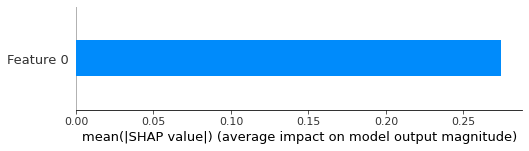

In [ ]:
import shap

for mag_col in 'u':
  model = reg[mag_col]
  shap_values = shap.TreeExplainer(model).shap_values(x_train)
  shap.summary_plot(shap_values, x_train, plot_type="bar")

# MLP

## *_mag --> ?_err (sklearn)


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# we need to store one regressor for each magnitude band.
regressors = dict()

e_sufix = 'Err'

predictors = []
for mag_col in 'ugriz':
  predictors.append(mag_col)

x_train = df_train[predictors].to_numpy()
x_test = df_test[predictors].to_numpy()

hyperparameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

for mag_col in 'ugriz':
  mag_err_col = mag_col + e_sufix
#  x_train = x_train[:, np.newaxis]
  y_train = df_train[mag_err_col].values

  regressors[mag_col] = MLPRegressor(random_state=1, max_iter=500)
  clf = GridSearchCV(regressors[mag_col], hyperparameter_space, n_jobs=-1, cv=3)
  clf.fit(x_train, y_train)

  # Best parameter set
  print('Best parameters found on band %s:%s\n', (mag_col, clf.best_params_))

  y_test = df_test[mag_err_col].values

  mse = mean_squared_error(y_test, clf.predict(x_test))
  print("MSE (MLP regressor) on band %s: %.5f" % (mag_col, mse))

Best parameters found on band %s:%s
 ('u', {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'})
MSE (MLP regressor) on band u: 0.01858
Best parameters found on band %s:%s
 ('g', {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'})
MSE (MLP regressor) on band g: 0.00042
Best parameters found on band %s:%s
 ('r', {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'})
MSE (MLP regressor) on band r: 0.00019
Best parameters found on band %s:%s
 ('i', {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'})
MSE (MLP regressor) on band i: 0.00021
Best parameters found on band %s:%s
 ('z', {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'})
MSE (MLP regressor) on band z: 0.00072


## *_mag --> ?_err (Keras)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(5,)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  #optimizer = tf.keras.optimizers.RMSprop(0.0001)

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=['mae', 'mse'])

  return model

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 8.8MB/s 


In [ ]:
import kerastuner as kt

predictors = []
for mag_col in 'ugriz':
  predictors.append(mag_col)

x_train = df_train[predictors].to_numpy()
x_test = df_test[predictors].to_numpy()

e_sufix = 'Err'

for mag_col in 'u':
  mag_err_col = mag_col + e_sufix
  y_train = df_train[mag_err_col].values
  y_test = df_test[mag_err_col].values

  tuner = kt.Hyperband(model_builder,
                      objective = 'val_mse',
                      max_epochs = 10,
                      factor = 3,
                      directory = 'my_dir',
                      project_name = 'intro_to_kt')

  tuner.search(x_train, 
               y_train, 
               epochs=500, 
               validation_split=0.2)#, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_kt/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/intro_to_kt/tuner0.json
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 448 and the optimal learning rate for the optimizer
is 0.001.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=500, validation_split=0.2)

val_mse_per_epoch = history.history['val_mse']
best_epoch = val_mse_per_epoch.index(min(val_mse_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/500
1487/1487 [==============================] - 4s 2ms/step - loss: 0.1389 - mae: 0.2073 - mse: 0.1389 - val_loss: 0.0960 - val_mae: 0.2054 - val_mse: 0.0960
Epoch 2/500
1487/1487 [==============================] - 3s 2ms/step - loss: 0.0354 - mae: 0.1436 - mse: 0.0354 - val_loss: 0.0504 - val_mae: 0.1682 - val_mse: 0.0504
Epoch 3/500
1487/1487 [==============================] - 3s 2ms/step - loss: 0.0276 - mae: 0.1230 - mse: 0.0276 - val_loss: 0.0508 - val_mae: 0.1357 - val_mse: 0.0508
Epoch 4/500
1487/1487 [==============================] - 3s 2ms/step - loss: 0.0232 - mae: 0.1102 - mse: 0.0232 - val_loss: 0.0480 - val_mae: 0.1318 - val_mse: 0.0480
Epoch 5/500
1487/1487 [==============================] - 3s 2ms/step - loss: 0.0200 - mae: 0.1017 - mse: 0.0200 - val_loss: 0.0710 - val_mae: 0.1951 - val_mse: 0.0710
Epoch 6/500
1487/1487 [==============================] - 3s 2ms/step - loss: 0.0176 - mae: 0.0955 - mse: 0.0176 - val_loss: 0.0434 - val_mae: 0.1255 - val_mse: 0.043

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x_train, y_train, epochs = best_epoch, validation_split = 0.0)

Epoch 1/46
1858/1858 [==============================] - 4s 2ms/step - loss: 0.2488 - mae: 0.2450 - mse: 0.2488
Epoch 2/46
1858/1858 [==============================] - 4s 2ms/step - loss: 0.0434 - mae: 0.1567 - mse: 0.0434
Epoch 3/46
1858/1858 [==============================] - 4s 2ms/step - loss: 0.0333 - mae: 0.1324 - mse: 0.0333
Epoch 4/46
1858/1858 [==============================] - 4s 2ms/step - loss: 0.0273 - mae: 0.1171 - mse: 0.0273
Epoch 5/46
1858/1858 [==============================] - 4s 2ms/step - loss: 0.0244 - mae: 0.1091 - mse: 0.0244
Epoch 6/46
1858/1858 [==============================] - 4s 2ms/step - loss: 0.0223 - mae: 0.1047 - mse: 0.0223
Epoch 7/46
1858/1858 [==============================] - 4s 2ms/step - loss: 0.0210 - mae: 0.1016 - mse: 0.0210
Epoch 8/46
1858/1858 [==============================] - 4s 2ms/step - loss: 0.0189 - mae: 0.0971 - mse: 0.0189
Epoch 9/46
1858/1858 [==============================] - 4s 2ms/step - loss: 0.0192 - mae: 0.0977 - mse: 0.0192
E

In [ ]:
eval_result = hypermodel.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

465/465 [==============================] - 1s 1ms/step - loss: 0.0166 - mae: 0.0901 - mse: 0.0166
[test loss, test accuracy]: [0.01656155101954937, 0.0901169553399086, 0.01656155101954937]


# Isotonic Reg

In [ ]:
from sklearn.isotonic import IsotonicRegression
import pandas as pd

def fit_isotonic_regression(df, mag, magErr):
  df_temp = df.copy(deep=True)
  df_temp.sort_values(by=[mag], inplace=True)
  df_temp = df_temp.reset_index(drop=True)
  x = df[mag]
  y = df[magErr]
  isoreg = IsotonicRegression()
  isoreg.fit_transform(x, y)
  return isoreg

In [ ]:
from sklearn.linear_model import LinearRegression

def fit_linear_regression(df, mag, magErr):
  x = df[mag].to_numpy()
  y = df[magErr]
  lr = LinearRegression()
  lr.fit(x[:, np.newaxis], y)  # x needs to be 2d for LinearRegression  isoreg = IsotonicRegression()
  return lr

## Model evaluation

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

e_prefix = ''
e_sufix = 'Err'

for mag_col in 'uriz':
    mag_err_col = e_prefix + mag_col + e_sufix

    isoreg = fit_isotonic_regression(df_train, mag_col, mag_err_col)
    lr  = fit_linear_regression(df_train, mag_col, mag_err_col)

    y_test = df_test[mag_err_col].values

    y_pred = isoreg.predict(df_test[mag_col])
    mse = mean_squared_error(y_test, y_pred)
    print("MSE (isoreg) on band %s: %.5f" % (mag_col, mse))

    x_test = df_test[mag_col].to_numpy()
    x_test = x_test[:, np.newaxis]
    y_pred = lr.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    print("MSE (linreg) on band %s: %.5f" % (mag_col, mse))

    print()

MSE (isoreg) on band u: 0.01487
MSE (linreg) on band u: 0.01699

MSE (isoreg) on band r: 0.00018
MSE (linreg) on band r: 0.00020

MSE (isoreg) on band i: 0.00021
MSE (linreg) on band i: 0.00022

MSE (isoreg) on band z: 0.00062
MSE (linreg) on band z: 0.00069



# ANN

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.1


In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[1]),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.0001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
from sklearn.preprocessing import StandardScaler

def norm(data):
  scaler = StandardScaler()
  scaler.fit(data)
  return scaler.transform(data)

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error

# Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 50 == 0: print('')
    print('.', end='')

EPOCHS = 200

e_prefix = ''
e_sufix = 'Err'

history = dict()
y_test = dict()
y_pred = dict()

for mag_col in 'ugriz':
    df_copy = df_train.copy(deep=True)
    mag_err_col = e_prefix + mag_col + e_sufix

    y_train = df_train[mag_err_col].values
    x_train = df_train[mag_col].to_numpy()
    x_train = x_train[:, np.newaxis]
    normed_train_data = norm(x_train)

    model = build_model()

    history[mag_col] = model.fit(
      normed_train_data, y_train, batch_size=256,
      epochs=EPOCHS, validation_split = 0.2, verbose=0,
      callbacks=None)
    
    y_test[mag_col] = df_test[mag_err_col].values
    x_test = df_test[mag_col].to_numpy()
    x_test = x_test[:, np.newaxis]
    normed_test_data = norm(x_test)
    y_pred[mag_col] = model.predict(normed_test_data).flatten()
    mse = mean_squared_error(y_test[mag_col], y_pred[mag_col])
    print("MSE (mlp) on band %s: %.5f" % (mag_col, mse))

MSE (mlp) on band u: 0.01541
MSE (mlp) on band g: 0.00033
MSE (mlp) on band r: 0.00017
MSE (mlp) on band i: 0.00021
MSE (mlp) on band z: 0.00059


In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
195,0.010100,0.067619,0.010100,0.037362,0.123780,0.037362,195
196,0.010093,0.067549,0.010093,0.033205,0.115821,0.033205,196
197,0.010095,0.067541,0.010095,0.035932,0.120141,0.035932,197
198,0.010106,0.067590,0.010106,0.037981,0.127321,0.037981,198
199,0.010103,0.067557,0.010103,0.037061,0.124518,0.037061,199


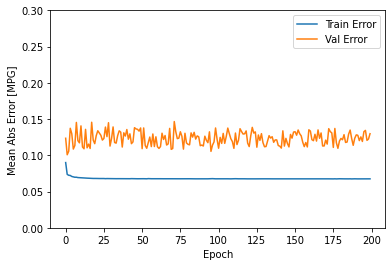

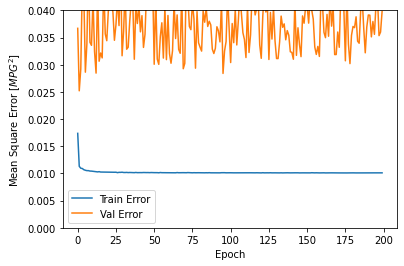

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,0.3])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,.04])
  plt.legend()
  plt.show()


plot_history(history)

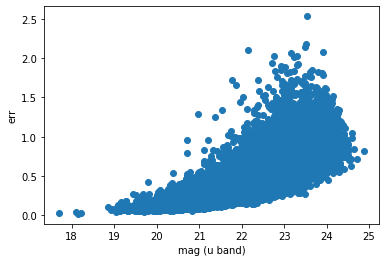

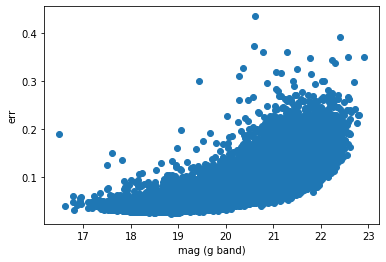

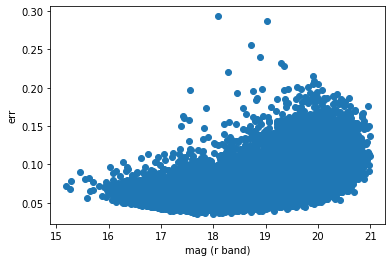

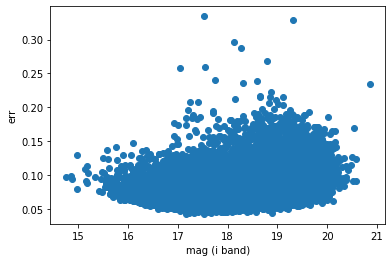

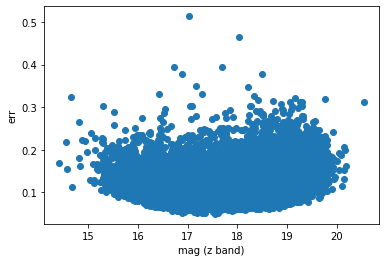

In [ ]:
for mag_col in 'ugriz':
  mag_err_col = e_prefix + mag_col + e_sufix
  train_labels = df_copy[mag_err_col].values
  x = df_copy[mag_col].to_numpy()
  y = df_copy[mag_err_col].to_numpy()
  plt.figure()
  plt.scatter(x, y)
  plt.xlabel("mag (%s band)" % mag_col)
  _ = plt.ylabel("err")

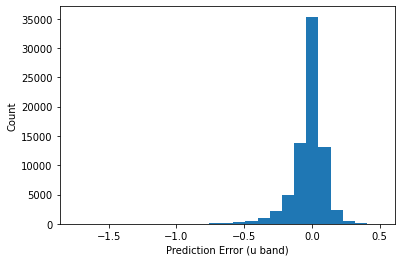

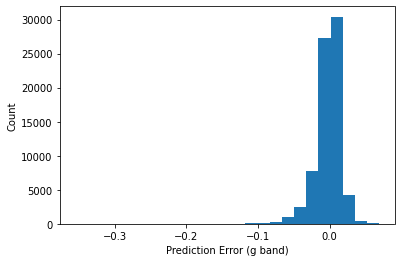

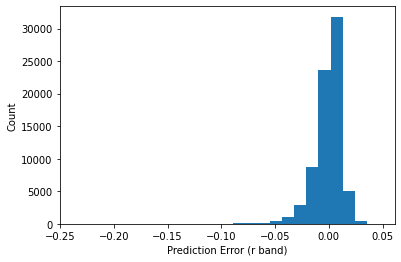

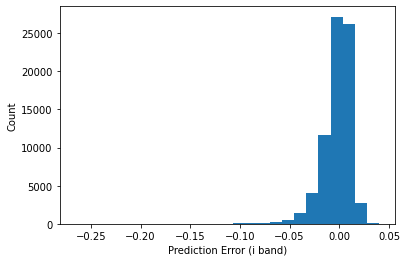

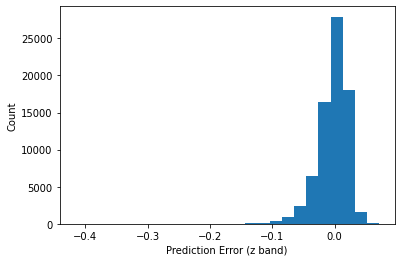

In [ ]:
for mag_col in 'ugriz':
  error = err_pred[mag_col] - err_true[mag_col]
  plt.figure()
  plt.hist(error, bins = 25)
  plt.xlabel("Prediction Error (%s band)" % mag_col)
  _ = plt.ylabel("Count")

# Gradient boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

reg = dict()

for mag_col in 'ugriz':
  mag_err_col = e_prefix + mag_col + e_sufix

  y_train = df_train[mag_err_col].values
  x_train = df_train[mag_col].to_numpy()
  x_train = x_train[:, np.newaxis]

  reg[mag_col] = GradientBoostingRegressor(**params)
  reg[mag_col].fit(x_train, y_train)

  y_test = df_test[mag_err_col].values
  x_test = df_test[mag_col].to_numpy()
  x_test = x_test[:, np.newaxis]

  mse = mean_squared_error(y_test, reg[mag_col].predict(x_test))
  print("MSE (gboost) on band %s: %.5f" % (mag_col, mse))

MSE (gboost) on band u: 0.01487
MSE (gboost) on band g: 0.00033
MSE (gboost) on band r: 0.00018
MSE (gboost) on band i: 0.00021
MSE (gboost) on band z: 0.00061


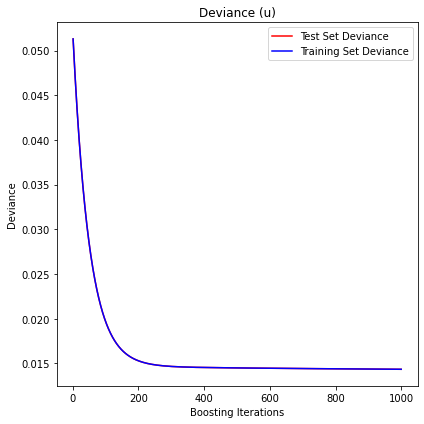

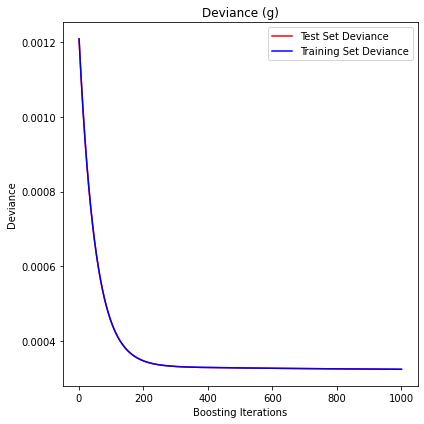

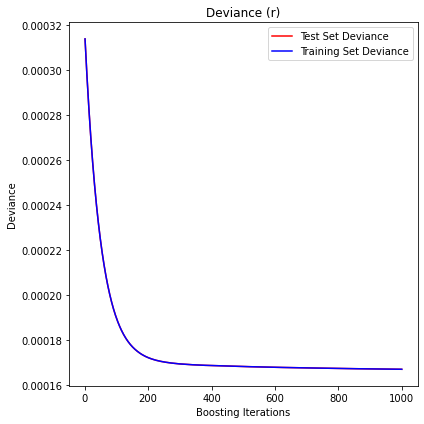

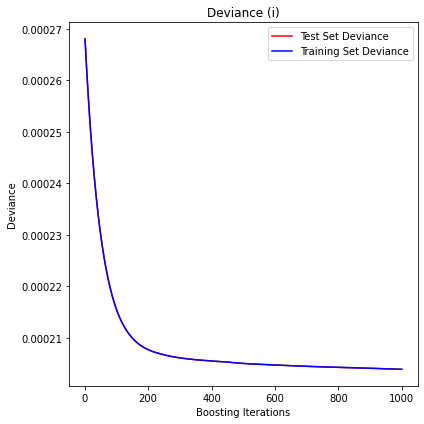

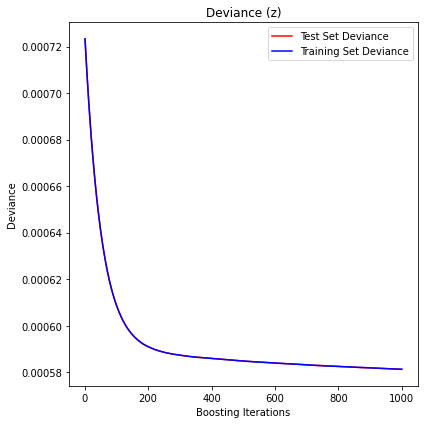

In [ ]:
for mag_col in 'ugriz':
  mag_err_col = e_prefix + mag_col + e_sufix

  test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

  x = df_copy[mag_col].to_numpy()
  x = x[:, np.newaxis]
  train_labels = df_copy[mag_err_col].values

  for i, y_pred in enumerate(reg[mag_col].staged_predict(x)):
      test_score[i] = reg[mag_col].loss_(train_labels, y_pred)

  fig = plt.figure(figsize=(6, 6))
  plt.subplot(1, 1, 1)
  plt.title('Deviance' + ' (' + mag_col + ')')

  plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
          label='Test Set Deviance')

  plt.plot(np.arange(params['n_estimators']) + 1, reg[mag_col].train_score_, 'b-',
          label='Training Set Deviance')

  plt.legend(loc='upper right')
  plt.xlabel('Boosting Iterations')
  plt.ylabel('Deviance')
  fig.tight_layout()
  plt.show()

# Residual plot

In [ ]:
df = teddy_train_df

mag = 'u'
magErr = 'uErr'

X = df[mag].to_numpy()
X = X[:, np.newaxis]

y = df[magErr]

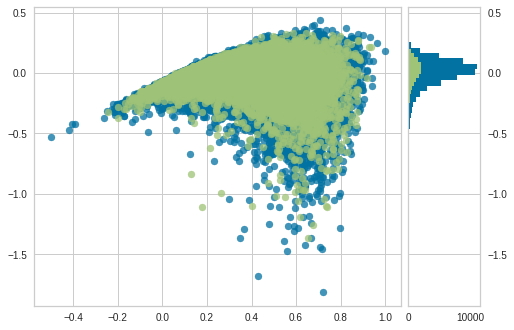

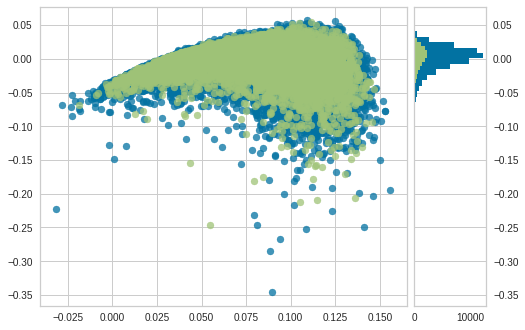

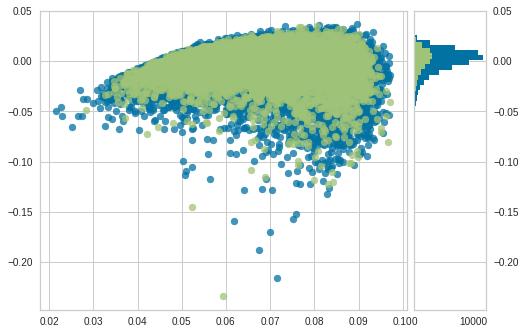

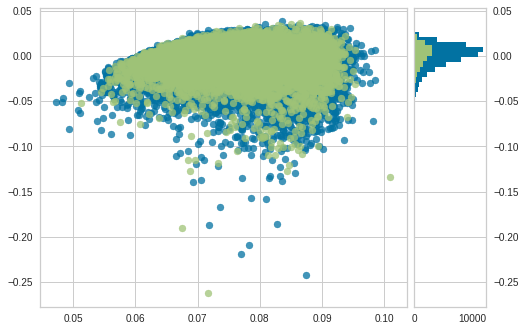

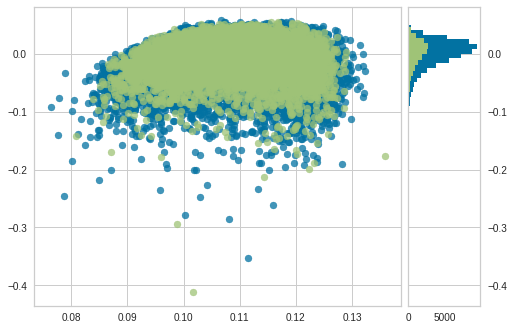

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot
import matplotlib.pyplot as plt

df = teddy_train_df

for mag_col in 'ugriz':
  plt.figure()

  mag_err_col = e_prefix + mag_col + e_sufix

  X = df[mag_col].to_numpy()
  X = X[:, np.newaxis]

  y = df[mag_err_col]

  # Create the train and test data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Instantiate the linear model and visualizer
  model = Ridge()
  visualizer = ResidualsPlot(model)

  visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
  visualizer.score(X_test, y_test)  # Evaluate the model on the test data